# Imports

In [1]:
# Standard libraries
import json
import os

# Data processing and numerical computation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Progress tracking
from tqdm import tqdm

# Computer vision
import cv2

# Machine learning utilities
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score, precision_score, recall_score

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras import Input, layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Collections
from collections import Counter

E0000 00:00:1752798514.648762      10 common_lib.cc:612] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: ===
learning/45eac/tfrc/runtime/common_lib.cc:230


# Configuration of TF to use TPU

In [2]:
tf.config.list_logical_devices()

I0000 00:00:1752729823.038208      10 service.cc:148] XLA service 0x557df3d19190 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752729823.038250      10 service.cc:156]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1752729823.038255      10 service.cc:156]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1752729823.038258      10 service.cc:156]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1752729823.038261      10 service.cc:156]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1752729823.038264      10 service.cc:156]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1752729823.038266      10 service.cc:156]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1752729823.038269      10 service.cc:156]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1752729823.038271      10 service.cc:156]   StreamExecutor device (7): TPU, 2a886c8


[LogicalDevice(name='/device:CPU:0', device_type='CPU'),
 LogicalDevice(name='/device:TPU:0', device_type='TPU'),
 LogicalDevice(name='/device:TPU:1', device_type='TPU'),
 LogicalDevice(name='/device:TPU:2', device_type='TPU'),
 LogicalDevice(name='/device:TPU:3', device_type='TPU'),
 LogicalDevice(name='/device:TPU:4', device_type='TPU'),
 LogicalDevice(name='/device:TPU:5', device_type='TPU'),
 LogicalDevice(name='/device:TPU:6', device_type='TPU'),
 LogicalDevice(name='/device:TPU:7', device_type='TPU'),
 LogicalDevice(name='/device:TPU_SYSTEM:0', device_type='TPU_SYSTEM')]

In [2]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='local')
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))
strategy = tf.distribute.TPUStrategy(resolver)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


I0000 00:00:1752798530.869076      10 service.cc:148] XLA service 0x5b0e8188a7d0 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752798530.869120      10 service.cc:156]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1752798530.869124      10 service.cc:156]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1752798530.869127      10 service.cc:156]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1752798530.869130      10 service.cc:156]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1752798530.869133      10 service.cc:156]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1752798530.869135      10 service.cc:156]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1752798530.869139      10 service.cc:156]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1752798530.869142      10 service.cc:156]   StreamExecutor device (7): TPU, 2a886c8


INFO:tensorflow:Finished initializing TPU system.
All devices:  [LogicalDevice(name='/device:TPU:0', device_type='TPU'), LogicalDevice(name='/device:TPU:1', device_type='TPU'), LogicalDevice(name='/device:TPU:2', device_type='TPU'), LogicalDevice(name='/device:TPU:3', device_type='TPU'), LogicalDevice(name='/device:TPU:4', device_type='TPU'), LogicalDevice(name='/device:TPU:5', device_type='TPU'), LogicalDevice(name='/device:TPU:6', device_type='TPU'), LogicalDevice(name='/device:TPU:7', device_type='TPU')]
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, T

In [3]:
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

# Data Aggregation

In [15]:
# json_dir = '/kaggle/input/fashion-product-images-dataset/fashion-dataset/styles/'
# image_dir = '/kaggle/input/fashion-product-images-dataset/fashion-dataset/images/'

# records = []

# json_files = [f for f in os.listdir(json_dir) if f.endswith('.json')]

# for fname in tqdm(json_files, desc="Processing JSON files"):
#     with open(os.path.join(json_dir, fname)) as f:
#         meta = json.load(f)
#         data = meta['data']

#     record = {
#         'id': data['id'],
#         'image_path': os.path.join(image_dir, str(data['id']) + '.jpg'),
#         'gender': data['gender'],
#         'masterCategory': data['masterCategory']['typeName'],
#         'subCategory': data['subCategory']['typeName'],
#         'articleType': data['articleType']['typeName'],
#         'baseColour': data['baseColour'],
#         'season': data['season'],
#         'usage': data['usage'],
#         'brandName': data['brandName'],
#         # 'variantName': data['variantName'],
#         # 'productDisplayName': data['productDisplayName'], You can uncomment this if you needed the true caption as well.
#     }

#     records.append(record)

# df = pd.DataFrame(records)

# directory = '/kaggle/working/merged-dataset'
# if not os.path.exists(directory):
#     os.makedirs(directory)

# df.to_csv('/kaggle/working/merged-dataset/merged.csv', index=False)

Processing JSON files: 100%|██████████| 44446/44446 [07:35<00:00, 97.59it/s] 


# Dataset Orientation

In [4]:
df = pd.read_csv('/kaggle/input/merged-dataset/merged.csv')

In [6]:
df.head()

id                                         image_path gender  \
0   1566  /kaggle/input/fashion-product-images-dataset/f...    Men   
1  39342  /kaggle/input/fashion-product-images-dataset/f...    Men   
2  13182  /kaggle/input/fashion-product-images-dataset/f...    Men   
3  21762  /kaggle/input/fashion-product-images-dataset/f...    Men   
4  48692  /kaggle/input/fashion-product-images-dataset/f...  Women   

  masterCategory subCategory   articleType baseColour  season   usage  \
0    Accessories    Headwear          Caps      Black  Summer  Sports   
1       Footwear       Shoes  Casual Shoes      Black  Summer  Casual   
2       Footwear       Shoes  Sports Shoes      Black    Fall  Sports   
3    Accessories       Belts         Belts      Black    Fall  Casual   
4    Accessories   Jewellery      Earrings     Silver  Summer  Casual   

  brandName variantName                     productDisplayName  
0   Artengo       Black                  Artengo Men Black Cap  
1      FILA     ZOOM HI              Fila Men Zoom Black Shoes  
2      FILA   Dls Maxim  FILA Men Dls Maxim Black Sports Shoes  
3    Fossil        Mead             Fossil Men Mead Black Belt  
4    Lucera      Silver           Lucera Women Silver Earrings

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44446 entries, 0 to 44445
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   id                  44446 non-null  int64 
 1   image_path          44446 non-null  object
 2   gender              44446 non-null  object
 3   masterCategory      44446 non-null  object
 4   subCategory         44446 non-null  object
 5   articleType         44446 non-null  object
 6   baseColour          44446 non-null  object
 7   season              44446 non-null  object
 8   usage               44446 non-null  object
 9   brandName           44446 non-null  object
 10  variantName         44446 non-null  object
 11  productDisplayName  44446 non-null  object
dtypes: int64(1), object(11)
memory usage: 4.1+ MB


In [10]:
df.shape

(44446, 12)

# Exploratory Data Analysis

In [11]:
df.isna().sum()

id                    0
image_path            0
gender                0
masterCategory        0
subCategory           0
articleType           0
baseColour            0
season                0
usage                 0
brandName             0
variantName           0
productDisplayName    0
dtype: int64

In [5]:
cat_cols = df.columns.drop(['id', 'image_path', 'variantName', 'productDisplayName'])

In [15]:
for col in cat_cols:
  print(f'Unique Values for {col}')
  print(df[col].unique())
  print('------------------------------------------------------------------------')

Unique Values for gender
['Men' 'Women' 'Unisex' 'Girls' 'Boys']
------------------------------------------------------------------------
Unique Values for masterCategory
['Accessories' 'Footwear' 'Apparel' 'Personal Care' 'Sporting Goods'
 'Free Items' 'Home']
------------------------------------------------------------------------
Unique Values for subCategory
['Headwear' 'Shoes' 'Belts' 'Jewellery' 'Topwear' 'Fragrance' 'Dress'
 'Bottomwear' 'Lips' 'Bags' 'Scarves' 'Sandal' 'Innerwear'
 'Loungewear and Nightwear' 'Saree' 'Watches' 'Socks' 'Eyewear'
 'Flip Flops' 'Accessories' 'Wallets' 'Apparel Set' 'Makeup' 'Nails'
 'Cufflinks' 'Hair' 'Skin' 'Ties' 'Sports Equipment' 'Stoles' 'Eyes'
 'Free Gifts' 'Gloves' 'Skin Care' 'Bath and Body' 'Shoe Accessories'
 'Mufflers' 'Perfumes' 'Wristbands' 'Water Bottle' 'Beauty Accessories'
 'Sports Accessories' 'Umbrellas' 'Vouchers' 'Home Furnishing']
------------------------------------------------------------------------
Unique Values for article

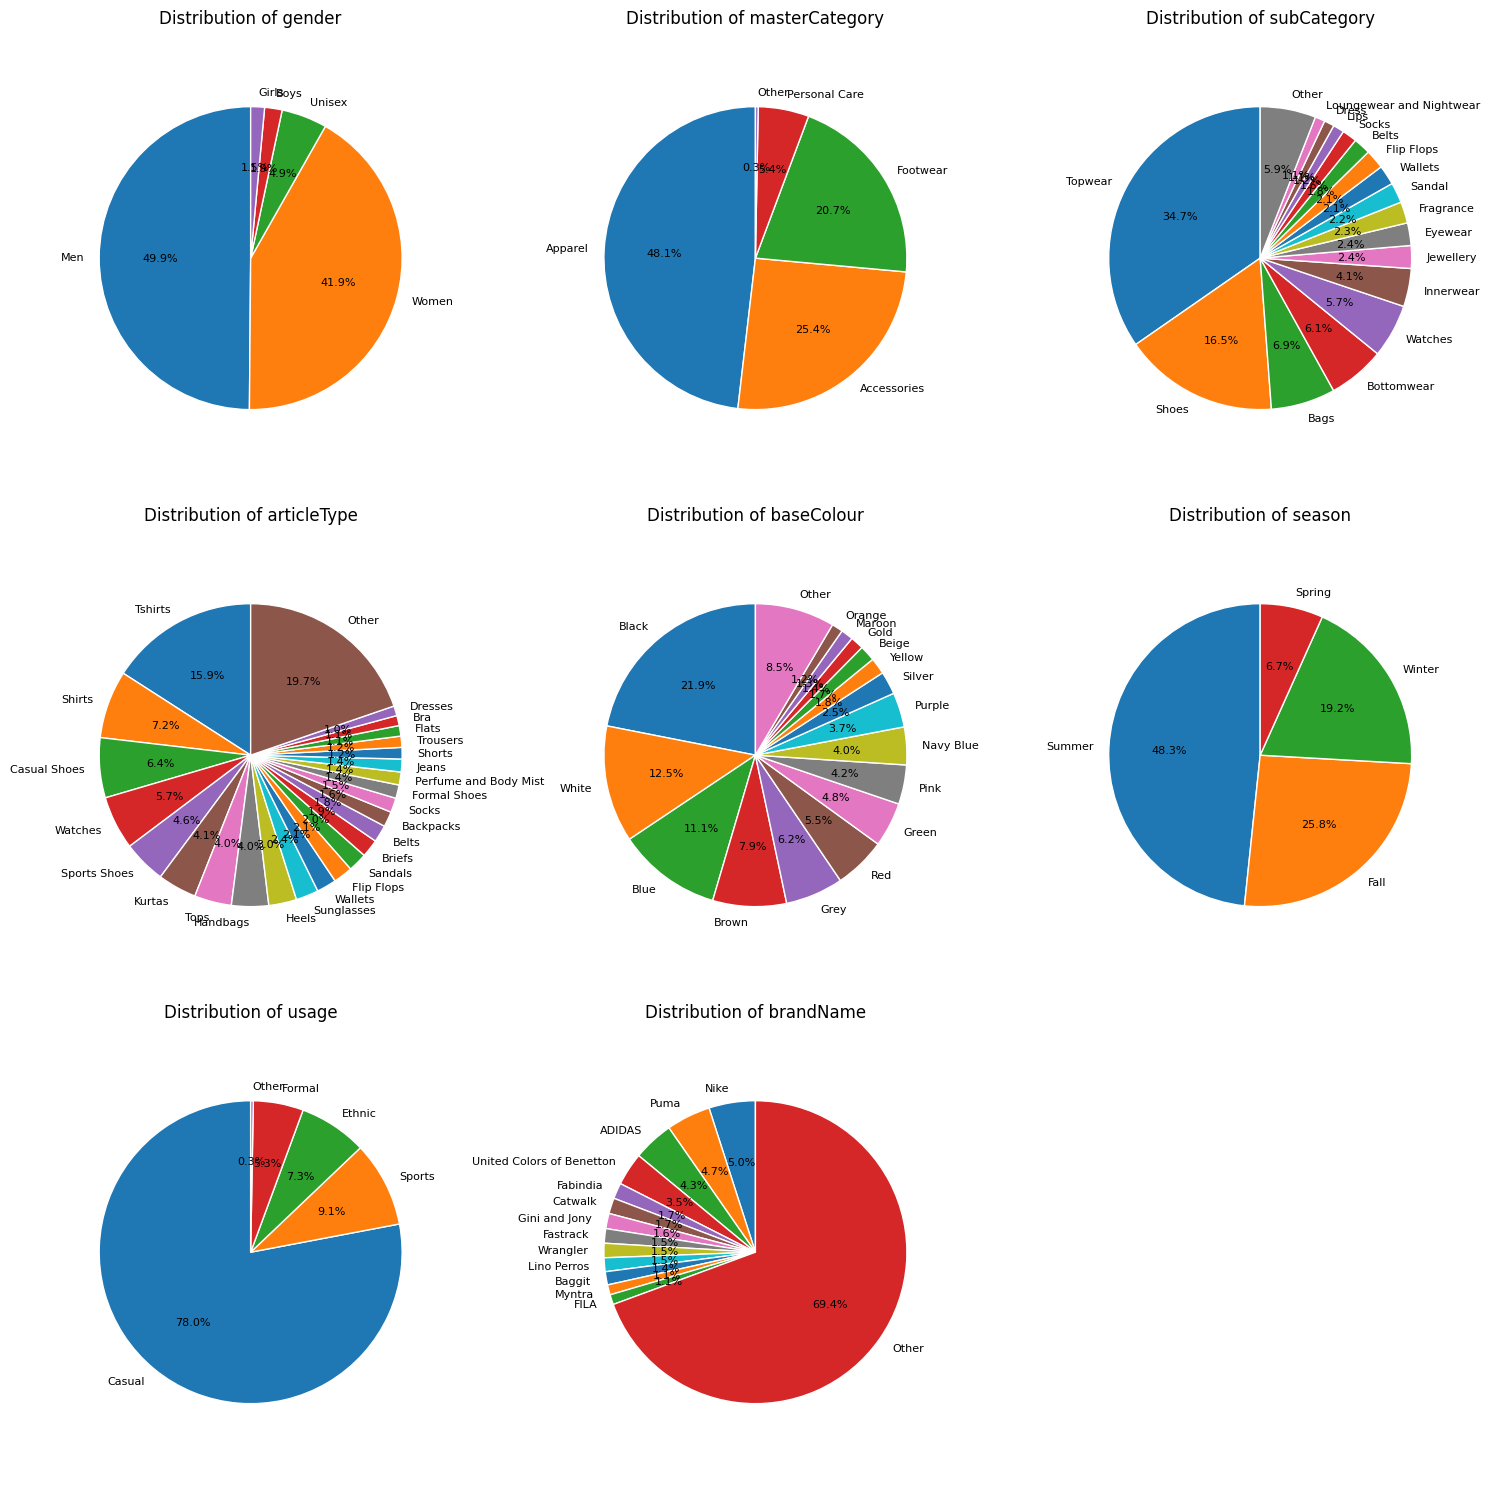

In [6]:
# Calculate number of rows and columns for subplots
n_cols = 3  # Number of columns in the subplot grid
n_rows = int(np.ceil(len(cat_cols) / n_cols))

# Create figure with subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
axes = axes.flatten()  # Flatten in case of single row

for i, col in enumerate(cat_cols):
    if i >= len(axes):  # In case we have more columns than subplots
        break

    # Calculate value counts and percentages
    value_counts = df[col].value_counts(normalize=True) * 100

    # Group small categories into 'Other'
    mask = value_counts < 1
    other_sum = value_counts[mask].sum()
    value_counts = value_counts[~mask]
    if other_sum > 0:
        value_counts['Other'] = other_sum

    # Create pie chart
    ax = axes[i]
    wedges, texts, autotexts = ax.pie(value_counts,
                                      labels=value_counts.index,
                                      autopct='%1.1f%%',
                                      startangle=90,
                                      wedgeprops={'linewidth': 1, 'edgecolor': 'white'})

    # Equal aspect ratio ensures that pie is drawn as a circle
    ax.axis('equal')
    ax.set_title(f'Distribution of {col}')

    # Adjust text properties for better readability
    for text in texts + autotexts:
        text.set_fontsize(8)

# Hide any unused subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

# Data Preprocessing

## Handling of Missing Values:

In [6]:
missing = [p for p in df['image_path'] if not os.path.exists(p)]
df = df[~df['image_path'].isin(missing)]  # Keep only rows with valid paths

for col in cat_cols:
    col_mode = df[col].mode()[0]
    df.loc[:, col] = df[col].fillna(col_mode)  # Explicitly modify the original DataFrame

## Feature Encoding:

In [7]:
target_cols = cat_cols

label_encoders = {}
for col in target_cols:
    le = LabelEncoder()
    df.loc[:, col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Train & Evaluation

## Training

### TF Dataset Definition:

In [8]:
def create_dataset(image_paths, labels_dict, batch_size=64, shuffle=False, img_size=(224, 224)):
    path_ds = tf.data.Dataset.from_tensor_slices(image_paths)
    
    # Only labels (no weights)
    label_ds = tf.data.Dataset.from_tensor_slices({col: labels_dict[col] for col in target_cols})

    ds = tf.data.Dataset.zip((path_ds, label_ds))

    if shuffle:
        ds = ds.shuffle(buffer_size=len(image_paths), reshuffle_each_iteration=True)

    def process(path, label_dict):
        image = tf.io.read_file(path)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, img_size)
        image = tf.cast(image, tf.float32) / 255.0

        return image, label_dict

    ds = ds.map(process, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

### Train / Validation Splitting:

In [9]:
image_paths = df['image_path'].tolist()
labels = df[target_cols].values

X_train, X_val, y_train, y_val = train_test_split(image_paths, labels, test_size=0.2, random_state=42)

IMG_SIZE = (224, 224)

labels_dict_train = {
    col: np.array(y_train[:, i], dtype=np.int32) for i, col in enumerate(target_cols)
}
labels_dict_val = {
    col: np.array(y_val[:, i], dtype=np.int32) for i, col in enumerate(target_cols)
}

train_ds = create_dataset(X_train, labels_dict_train, batch_size=BATCH_SIZE, img_size=IMG_SIZE)
val_ds   = create_dataset(X_val, labels_dict_val, batch_size=BATCH_SIZE, img_size=IMG_SIZE)

### Model Definition & Train:

#### Definition of Custom Callback for Calculating f1_score, Recall, and Precision at each Epoch:

In [10]:
class MultiHeadMetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, val_data, target_cols):
        super().__init__()
        self.val_ds = val_data
        self.target_cols = target_cols

        # Dictionary to store metrics per task
        self.history = {
            col: {
                'f1_macro': [],
                'precision_macro': [],
                'recall_macro': [],
                'f1_weighted': [],
                'precision_weighted': [],
                'recall_weighted': [],
            } for col in target_cols
        }

    def on_epoch_end(self, epoch, logs=None):
        y_trues = {col: [] for col in self.target_cols}
        y_preds = {col: [] for col in self.target_cols}
    
        for x_batch, y_batch in self.val_ds:
            y_pred_batch = self.model(x_batch, training=False)
    
            for col in self.target_cols:
                y_trues[col].extend(y_batch[col].numpy().tolist())
                y_preds[col].extend(np.argmax(y_pred_batch[col].numpy(), axis=1).tolist())
    
        for col in self.target_cols:
            y_true = np.array(y_trues[col])
            y_pred = np.array(y_preds[col])
    
            self.history[col]['f1_macro'].append(f1_score(y_true, y_pred, average='macro', zero_division=0))
            self.history[col]['precision_macro'].append(precision_score(y_true, y_pred, average='macro', zero_division=0))
            self.history[col]['recall_macro'].append(recall_score(y_true, y_pred, average='macro', zero_division=0))
    
            self.history[col]['f1_weighted'].append(f1_score(y_true, y_pred, average='weighted', zero_division=0))
            self.history[col]['precision_weighted'].append(precision_score(y_true, y_pred, average='weighted', zero_division=0))
            self.history[col]['recall_weighted'].append(recall_score(y_true, y_pred, average='weighted', zero_division=0))

#### Model Configuration - Phase 1:

In [12]:
with strategy.scope():
    base_model = EfficientNetB0(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
    base_model.trainable = False  # freeze base initially

    inputs = Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)

    outputs = {
        col: Dense(df[col].nunique(), activation='softmax', name=col)(x)
        for col in target_cols
    }

    model = Model(inputs, outputs)

    metrics_cb_phase_1 = MultiHeadMetricsCallback(val_data=val_ds, target_cols=target_cols)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=5e-3),
        loss={col:'sparse_categorical_crossentropy' for col in target_cols} ,
        loss_weights={col:1.0 for col in target_cols} ,
        metrics={col:'accuracy' for col in target_cols}
    )

    early_stopping_phase_1 = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )
    
    history_phase_1 = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=25,
        callbacks=[early_stopping_phase_1, metrics_cb_phase_1]
    )

I0000 00:00:1752798715.736587      10 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/25


I0000 00:00:1752798747.827783      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:9492960807655341432
I0000 00:00:1752798750.805057     791 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(7618343857965586787), session_name()
I0000 00:00:1752798770.266679     791 tpu_compile_op_common.cc:245] Compilation of 7618343857965586787 with session name  took 19.461569176s and succeeded
I0000 00:00:1752798770.351818     791 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(7618343857965586787), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_9492960807655341432", property.function_library_fingerprint = 9236956056876982290, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z 

277/278 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - articleType_accuracy: 0.1493 - articleType_loss: 3.7470 - baseColour_accuracy: 0.2116 - baseColour_loss: 2.8498 - brandName_accuracy: 0.0412 - brandName_loss: 5.2304 - gender_accuracy: 0.4756 - gender_loss: 1.0407 - loss: 18.6390 - masterCategory_accuracy: 0.4647 - masterCategory_loss: 1.2224 - season_accuracy: 0.4579 - season_loss: 1.2367 - subCategory_accuracy: 0.3284 - subCategory_loss: 2.5003 - usage_accuracy: 0.7830 - usage_loss: 0.8117

I0000 00:00:1752798790.724207     827 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(16991182557155786682), session_name()
I0000 00:00:1752798809.072771     827 tpu_compile_op_common.cc:245] Compilation of 16991182557155786682 with session name  took 18.348521942s and succeeded
I0000 00:00:1752798809.133622     827 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(16991182557155786682), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_9492960807655341432", property.function_library_fingerprint = 9236956056876982290, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "12,224,224,3,;12,;12,;12,;12,;12,;12,;12,;12,;", property.guaranteed_c

278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - articleType_accuracy: 0.1494 - articleType_loss: 3.7466 - baseColour_accuracy: 0.2116 - baseColour_loss: 2.8496 - brandName_accuracy: 0.0412 - brandName_loss: 5.2301 - gender_accuracy: 0.4757 - gender_loss: 1.0406 - loss: 18.6376 - masterCategory_accuracy: 0.4647 - masterCategory_loss: 1.2223 - season_accuracy: 0.4580 - season_loss: 1.2366 - subCategory_accuracy: 0.3284 - subCategory_loss: 2.5001 - usage_accuracy: 0.7830 - usage_loss: 0.8116

I0000 00:00:1752798816.633689      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:4673996159918510080
I0000 00:00:1752798818.329430     788 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(17901457307378609570), session_name()
I0000 00:00:1752798827.013699     788 tpu_compile_op_common.cc:245] Compilation of 17901457307378609570 with session name  took 8.684225303s and succeeded
I0000 00:00:1752798827.030825     788 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(17901457307378609570), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_4673996159918510080", property.function_library_fingerprint = 16500372887703615371, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap()

278/278 ━━━━━━━━━━━━━━━━━━━━ 227s 709ms/step - articleType_accuracy: 0.1494 - articleType_loss: 3.7463 - baseColour_accuracy: 0.2116 - baseColour_loss: 2.8494 - brandName_accuracy: 0.0412 - brandName_loss: 5.2297 - gender_accuracy: 0.4757 - gender_loss: 1.0405 - loss: 18.6361 - masterCategory_accuracy: 0.4648 - masterCategory_loss: 1.2222 - season_accuracy: 0.4580 - season_loss: 1.2365 - subCategory_accuracy: 0.3285 - subCategory_loss: 2.4998 - usage_accuracy: 0.7830 - usage_loss: 0.8115 - val_articleType_accuracy: 0.1612 - val_articleType_loss: 3.5593 - val_baseColour_accuracy: 0.2234 - val_baseColour_loss: 2.7506 - val_brandName_accuracy: 0.0515 - val_brandName_loss: 5.0975 - val_gender_accuracy: 0.5050 - val_gender_loss: 0.9835 - val_loss: 17.8691 - val_masterCategory_accuracy: 0.4792 - val_masterCategory_loss: 1.1325 - val_season_accuracy: 0.4805 - val_season_loss: 1.1972 - val_subCategory_accuracy: 0.3465 - val_subCategory_loss: 2.3592 - val_usage_accuracy: 0.7788 - val_usage_loss

#### Model Configuration - Phase 2:

In [14]:
with strategy.scope(): 
    # Fine-tuning: unfreeze the base model
    base_model.trainable = True

    metrics_cb_phase_2 = MultiHeadMetricsCallback(val_data=val_ds, target_cols=target_cols)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
        loss={col:'sparse_categorical_crossentropy' for col in target_cols},
        loss_weights={col:1.0 for col in target_cols},
        metrics={col:'accuracy' for col in target_cols}
    )

    early_stopping_phase_2 = EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True,
        verbose=1
    )
    
    # Fitting - Phase 2
    history_phase_2 = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=50,
        callbacks=[early_stopping_phase_2, metrics_cb_phase_2]
    )

Epoch 1/50


I0000 00:00:1752802084.827018      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:2290724078647920945
I0000 00:00:1752802091.762039     782 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(10693740233690302996), session_name()
I0000 00:00:1752802129.269173     782 tpu_compile_op_common.cc:245] Compilation of 10693740233690302996 with session name  took 37.507052554s and succeeded
I0000 00:00:1752802129.422967     782 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(10693740233690302996), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_2290724078647920945", property.function_library_fingerprint = 11190276135347323757, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap(

277/278 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - articleType_accuracy: 0.1493 - articleType_loss: 5.3403 - baseColour_accuracy: 0.1690 - baseColour_loss: 3.8655 - brandName_accuracy: 0.0376 - brandName_loss: 7.3335 - gender_accuracy: 0.5094 - gender_loss: 1.3958 - loss: 25.3565 - masterCategory_accuracy: 0.6144 - masterCategory_loss: 1.3658 - season_accuracy: 0.4688 - season_loss: 1.6359 - subCategory_accuracy: 0.4296 - subCategory_loss: 3.3029 - usage_accuracy: 0.7566 - usage_loss: 1.1169

I0000 00:00:1752802168.544339     761 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(3664552270920094077), session_name()
I0000 00:00:1752802206.273597     761 tpu_compile_op_common.cc:245] Compilation of 3664552270920094077 with session name  took 37.729207078s and succeeded
I0000 00:00:1752802206.396253     761 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(3664552270920094077), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_2290724078647920945", property.function_library_fingerprint = 11190276135347323757, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "12,224,224,3,;12,;12,;12,;12,;12,;12,;12,;12,;", property.guaranteed_con

278/278 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - articleType_accuracy: 0.1495 - articleType_loss: 5.3348 - baseColour_accuracy: 0.1692 - baseColour_loss: 3.8629 - brandName_accuracy: 0.0376 - brandName_loss: 7.3278 - gender_accuracy: 0.5096 - gender_loss: 1.3948 - loss: 25.3345 - masterCategory_accuracy: 0.6147 - masterCategory_loss: 1.3642 - season_accuracy: 0.4689 - season_loss: 1.6345 - subCategory_accuracy: 0.4298 - subCategory_loss: 3.2993 - usage_accuracy: 0.7567 - usage_loss: 1.1162

I0000 00:00:1752802215.554871      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:4093426940838845112
I0000 00:00:1752802217.422458     765 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(6992959393905243136), session_name()
I0000 00:00:1752802226.474795     765 tpu_compile_op_common.cc:245] Compilation of 6992959393905243136 with session name  took 9.052279857s and succeeded
I0000 00:00:1752802226.497557     765 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(6992959393905243136), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_4093426940838845112", property.function_library_fingerprint = 5197029320664737063, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z =

278/278 ━━━━━━━━━━━━━━━━━━━━ 281s 786ms/step - articleType_accuracy: 0.1497 - articleType_loss: 5.3293 - baseColour_accuracy: 0.1693 - baseColour_loss: 3.8603 - brandName_accuracy: 0.0377 - brandName_loss: 7.3221 - gender_accuracy: 0.5098 - gender_loss: 1.3938 - loss: 25.3126 - masterCategory_accuracy: 0.6150 - masterCategory_loss: 1.3626 - season_accuracy: 0.4690 - season_loss: 1.6331 - subCategory_accuracy: 0.4300 - subCategory_loss: 3.2958 - usage_accuracy: 0.7567 - usage_loss: 1.1156 - val_articleType_accuracy: 0.1153 - val_articleType_loss: 7.4565 - val_baseColour_accuracy: 0.1984 - val_baseColour_loss: 3.2568 - val_brandName_accuracy: 0.0217 - val_brandName_loss: 7.6549 - val_gender_accuracy: 0.5346 - val_gender_loss: 1.5258 - val_loss: 31.7488 - val_masterCategory_accuracy: 0.5119 - val_masterCategory_loss: 3.2044 - val_season_accuracy: 0.4173 - val_season_loss: 1.7684 - val_subCategory_accuracy: 0.3774 - val_subCategory_loss: 5.9293 - val_usage_accuracy: 0.7785 - val_usage_loss

#### Merging Histories and Callbacks:

In [ ]:
def merge_phase_metrics(metrics_cb1, metrics_cb2, history1, history2, early1, early2, target_cols):
    """
    Truncate phase1 metrics/history at best epoch from early1, and merge with phase2.
    """
    # Use best_epoch from early stopping callback
    best_epoch1 = early1.best_epoch

    # Merge callback metrics
    merged_cb = {}
    for col in target_cols:
        merged_cb[col] = {}
        for key, vals1 in metrics_cb1.history[col].items():
            vals2 = metrics_cb2.history[col][key]
            merged_cb[col][key] = vals1[:best_epoch1+1] + vals2

    # Merge history metrics (accuracy keys)
    merged_history = {}
    for col in target_cols:
        train_key = f'{col}_accuracy'
        val_key = f'val_{col}_accuracy'
        merged_history[train_key] = history1.history[train_key][:best_epoch1+1] + history2.history[train_key]
        merged_history[val_key]   = history1.history[val_key][:best_epoch1+1]   + history2.history[val_key]
    
    merged_history['loss'] = history1.history['loss'][:best_epoch1+1] + history2.history['loss']
    merged_history['val_loss'] = history1.history['val_loss'][:best_epoch1+1] + history2.history['val_loss']

    return merged_cb, merged_history

In [ ]:
merged_cb, merged_history = merge_phase_metrics(
    metrics_cb_phase_1, metrics_cb_phase_2,
    history_phase_1, history_phase_2,
    early_stopping_phase_1, early_stopping_phase_2,
    target_cols
)

#### Plot of Losses During Training:

In [105]:
def plot_train_val_losses(merged_history, early1, early2):
    # Retrieve best epochs from callbacks
    best1 = early1.best_epoch + 1
    best2 = early2.best_epoch + 1
    overall_best = best1 + best2

    total_epochs = len(merged_history['loss'])
    epochs = np.arange(1, total_epochs + 1)

    plt.plot(epochs, merged_history['loss'], label='train loss')
    plt.plot(epochs, merged_history['val_loss'], label='val loss')
    plt.axvline(overall_best, linestyle='--', label='best_epoch')
    plt.title(f'{col} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Losses')
    plt.legend(loc='lower right')  # Fixed legend to the bottom-right corner

    plt.tight_layout()
    plt.show()

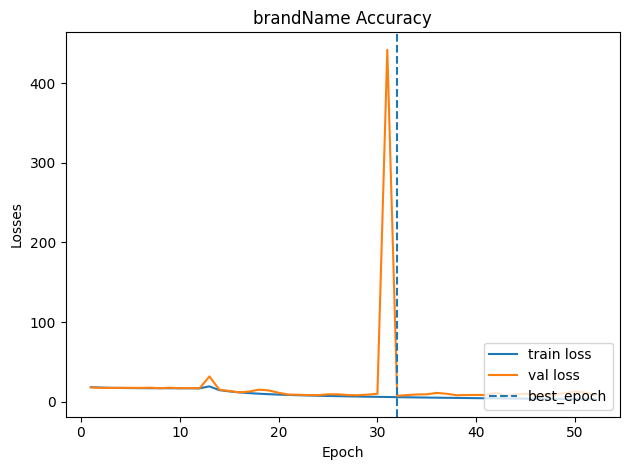

In [106]:
plot_train_val_losses(merged_history, early_stopping_phase_1, early_stopping_phase_2)

#### Saving the Model:

In [15]:
model.save('/kaggle/working/tag_prediction_EffNetB0.keras')

## Evaluation

### Plot of Accuracies and Scores (f1, Recall, and Precision) During Training:

In [77]:
def plot_multihead_metrics(merged_cb, merged_history, early1, early2, target_cols):
    """
    For each target column, plot:
      - Left: train/val accuracy (phase1 vs phase2)
      - Middle: F1 (weighted), precision, recall (weighted)
      - Right: F1 (macro), precision, recall (macro)
    Marks the overall best epoch.
    Legends are fixed to the bottom-right corner of each plot.
    """
    # Retrieve best epochs from callbacks
    best1 = early1.best_epoch + 1
    best2 = early2.best_epoch + 1
    overall_best = best1 + best2
    
    total_epochs = len(merged_history[f'{target_cols[0]}_accuracy'])
    epochs = np.arange(1, total_epochs + 1)

    fig, axes = plt.subplots(len(target_cols), 3, figsize=(15, 4 * len(target_cols)))
    
    for i, col in enumerate(target_cols):
        ax_acc = axes[i, 0]
        # Split indices
        e1 = best1 + 1
        # Accuracy data
        train_acc = merged_history[f'{col}_accuracy']
        val_acc   = merged_history[f'val_{col}_accuracy']
        # # Plot phase1
        # ax_acc.plot(epochs[:e1], train_acc[:e1], label='train_acc (phase1)')
        # ax_acc.plot(epochs[:e1], val_acc[:e1],   label='val_acc   (phase1)')
        # Plot phase2
        ax_acc.plot(epochs, train_acc, label='train_acc (phase2)')
        ax_acc.plot(epochs, val_acc,   label='val_acc   (phase2)')
        ax_acc.axvline(overall_best, linestyle='--', label='best_epoch')
        ax_acc.set_title(f'{col} Accuracy')
        ax_acc.set_xlabel('Epoch')
        ax_acc.set_ylabel('Accuracy')
        ax_acc.legend(loc='lower right')  # Fixed legend to the bottom-right corner

        # Middle plot for Weighted Metrics
        ax_met_weighted = axes[i, 1]
        f1w = merged_cb[col]['f1_weighted']
        prw = merged_cb[col]['precision_weighted']
        rcw = merged_cb[col]['recall_weighted']
        ax_met_weighted.plot(epochs, f1w, label='F1 (weighted)')
        ax_met_weighted.plot(epochs, prw, label='Precision (weighted)')
        ax_met_weighted.plot(epochs, rcw, label='Recall (weighted)')
        ax_met_weighted.axvline(overall_best, linestyle='--', label='best_epoch')
        ax_met_weighted.set_title(f'{col} Weighted Scores')
        ax_met_weighted.set_xlabel('Epoch')
        ax_met_weighted.set_ylabel('Score')
        ax_met_weighted.legend(loc='lower right')  # Fixed legend to the bottom-right corner

        # Right plot for Macro Metrics
        ax_met_macro = axes[i, 2]
        f1m = merged_cb[col]['f1_macro']
        prm = merged_cb[col]['precision_macro']
        rcm = merged_cb[col]['recall_macro']
        ax_met_macro.plot(epochs, f1m, label='F1 (macro)')
        ax_met_macro.plot(epochs, prm, label='Precision (macro)')
        ax_met_macro.plot(epochs, rcm, label='Recall (macro)')
        ax_met_macro.axvline(overall_best, linestyle='--', label='best_epoch')
        ax_met_macro.set_title(f'{col} Macro Scores')
        ax_met_macro.set_xlabel('Epoch')
        ax_met_macro.set_ylabel('Score')
        ax_met_macro.legend(loc='lower right')  # Fixed legend to the bottom-right corner
    
    plt.tight_layout()
    plt.show()

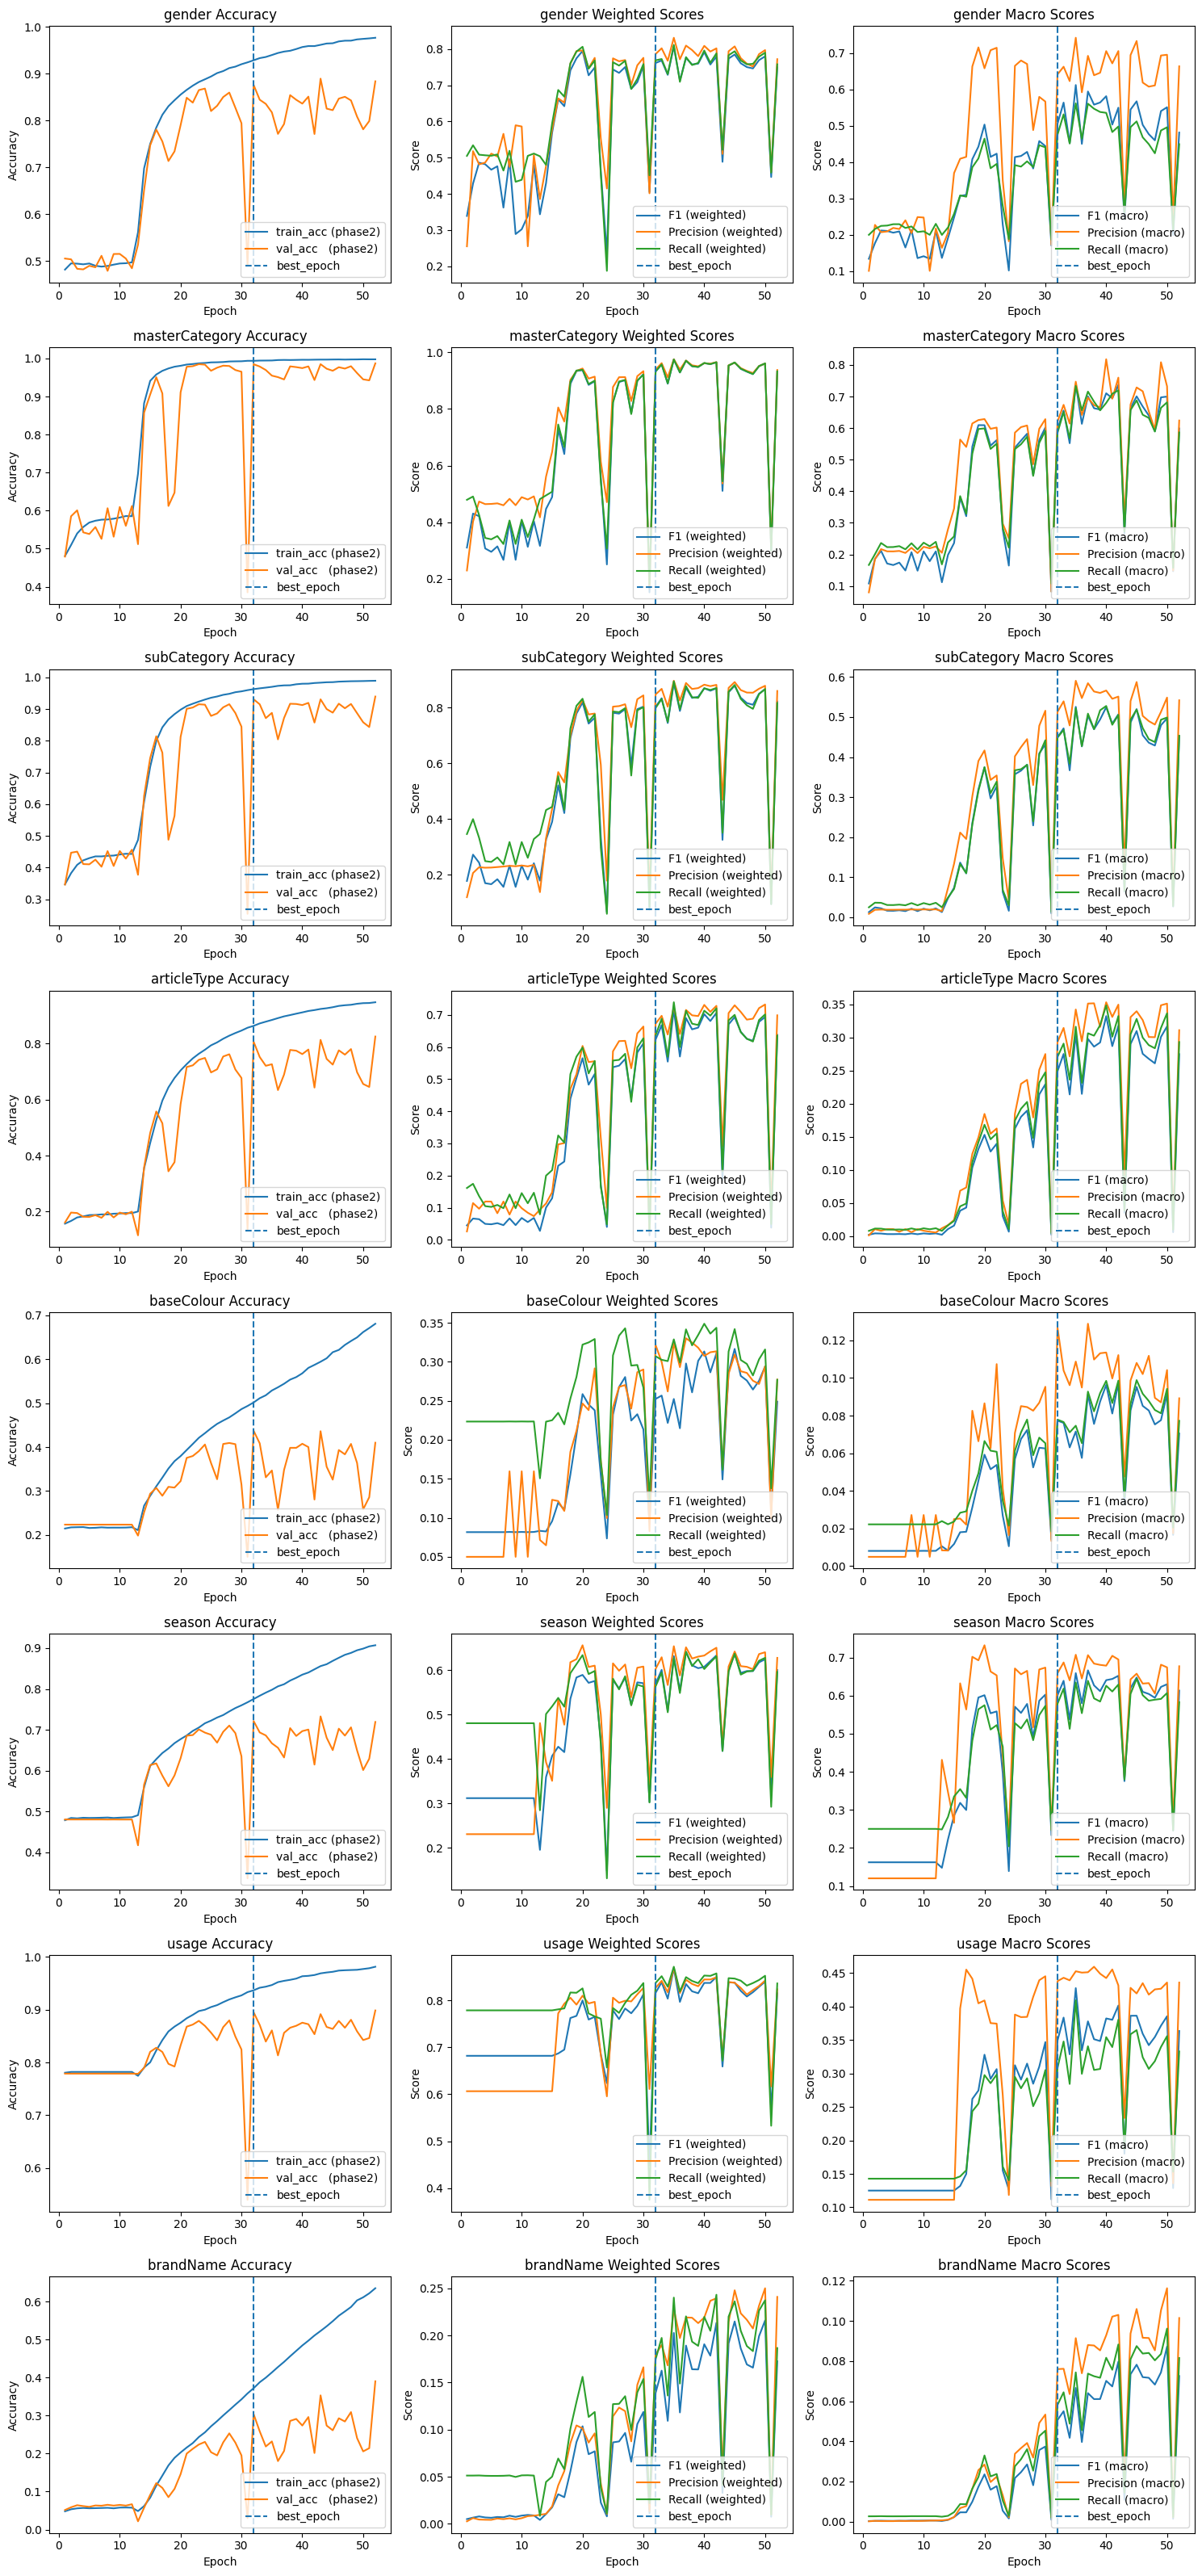

In [78]:
plot_multihead_metrics(merged_cb, merged_history,
    early_stopping_phase_1, early_stopping_phase_2,
    target_cols
)

### Loading the Model:

In [27]:
# with strategy.scope():
#     model = tf.keras.models.load_model('/kaggle/input/jkhj/tensorflow2/default/1/tag_pred_no_class_weight_eq_loss_effb0_5e-3_15_5e-5_50.keras')

### Confusion Matrices:

In [79]:
def get_predictions_and_labels(model, dataset, target_cols):
    all_preds = {col: [] for col in target_cols}
    all_trues = {col: [] for col in target_cols}

    for batch_images, batch_labels in dataset:
        preds = model(batch_images, training=False)

        if isinstance(preds, tf.Tensor):
            preds = {target_cols[0]: preds}

        for col in target_cols:
            pred_classes = np.argmax(preds[col].numpy(), axis=1)
            true_classes = batch_labels[col].numpy()
            all_preds[col].extend(pred_classes)
            all_trues[col].extend(true_classes)

    return all_preds, all_trues

def plot_confusion_matrix_topN(y_true, y_pred, labels, title, top_n=15):
    # Get top-N most frequent true labels
    counter = Counter(y_true)
    top_labels_idx = [label for label, _ in counter.most_common(top_n)]

    filtered_idx = [i for i, val in enumerate(y_true) if val in top_labels_idx]
    y_true_filtered = [y_true[i] for i in filtered_idx]
    y_pred_filtered = [y_pred[i] for i in filtered_idx]

    cm = confusion_matrix(y_true_filtered, y_pred_filtered, labels=top_labels_idx)
    
    class_names = [labels[i] for i in top_labels_idx]

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f"{title} (Top {top_n})")
    plt.tight_layout()
    plt.show()

Confusion Matrix for 'gender'


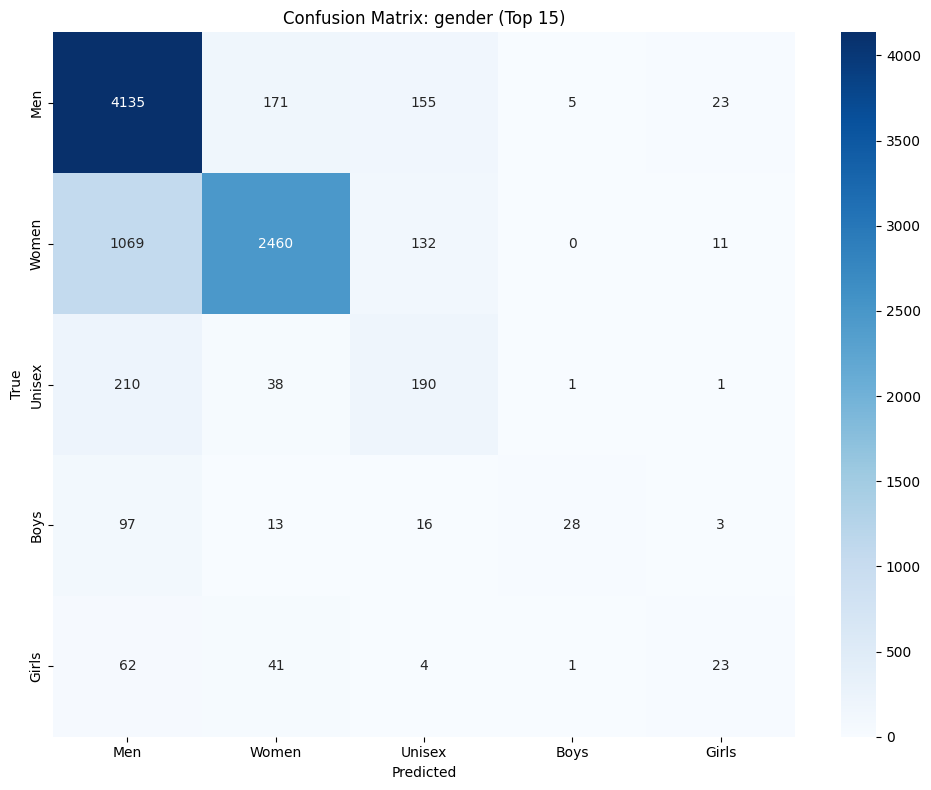

Confusion Matrix for 'masterCategory'


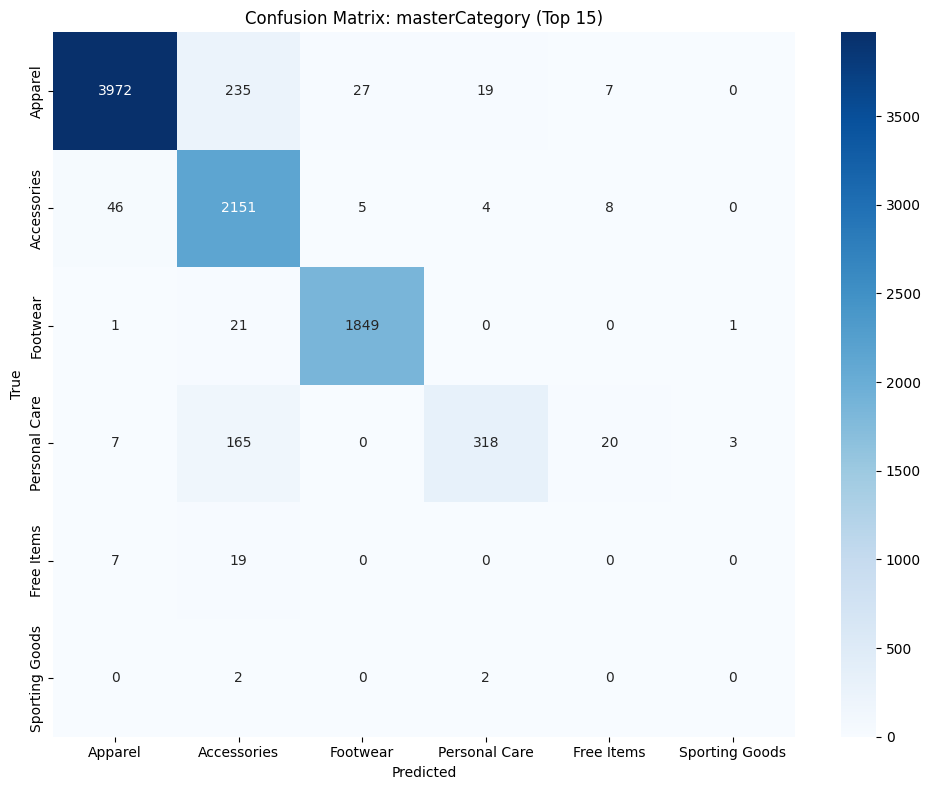

Confusion Matrix for 'subCategory'


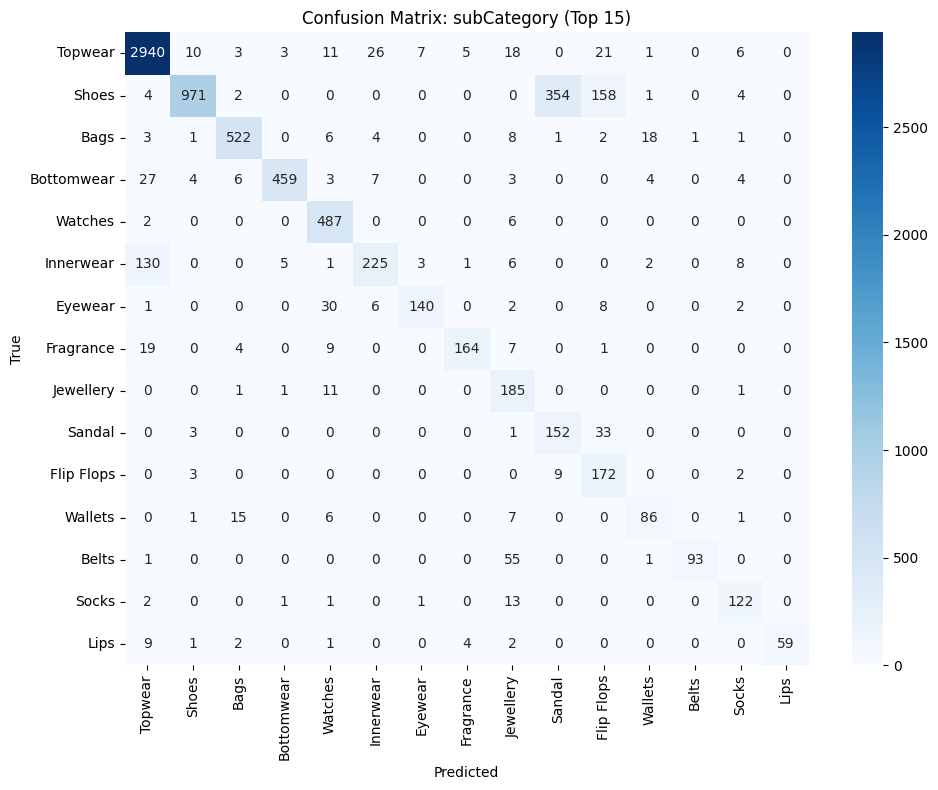

Confusion Matrix for 'articleType'


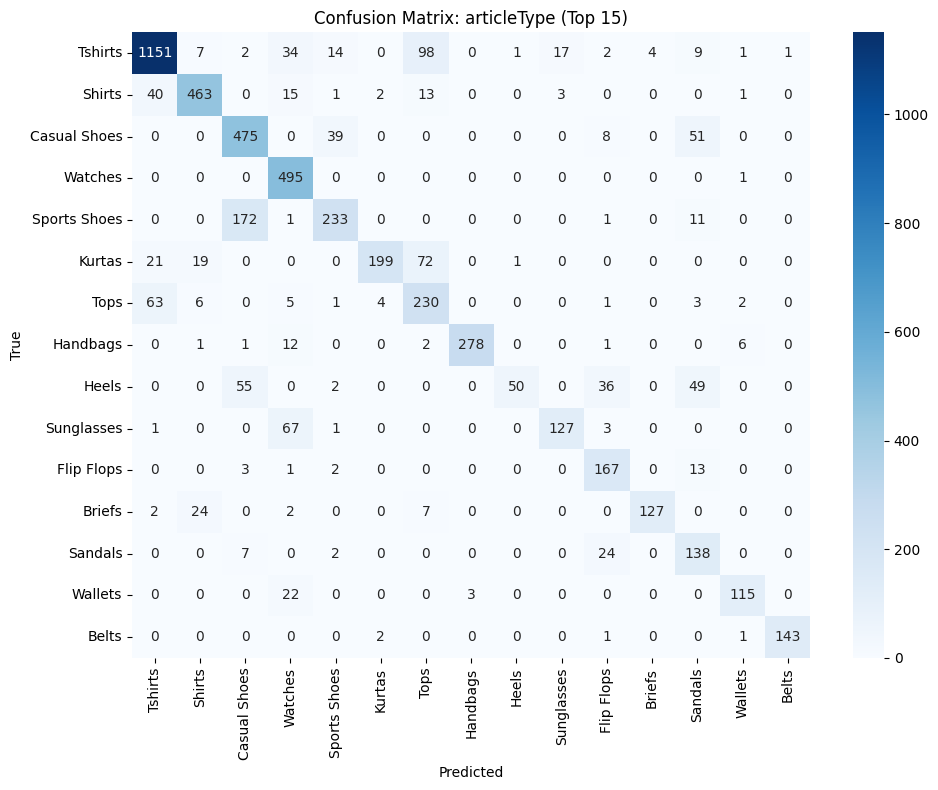

Confusion Matrix for 'baseColour'


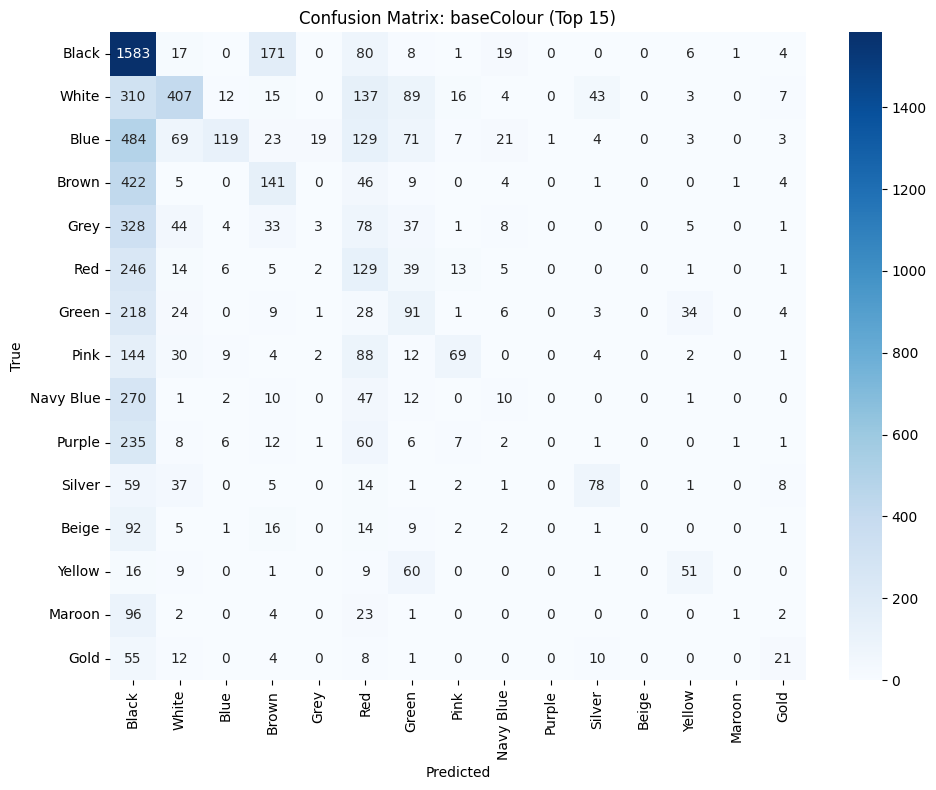

Confusion Matrix for 'season'


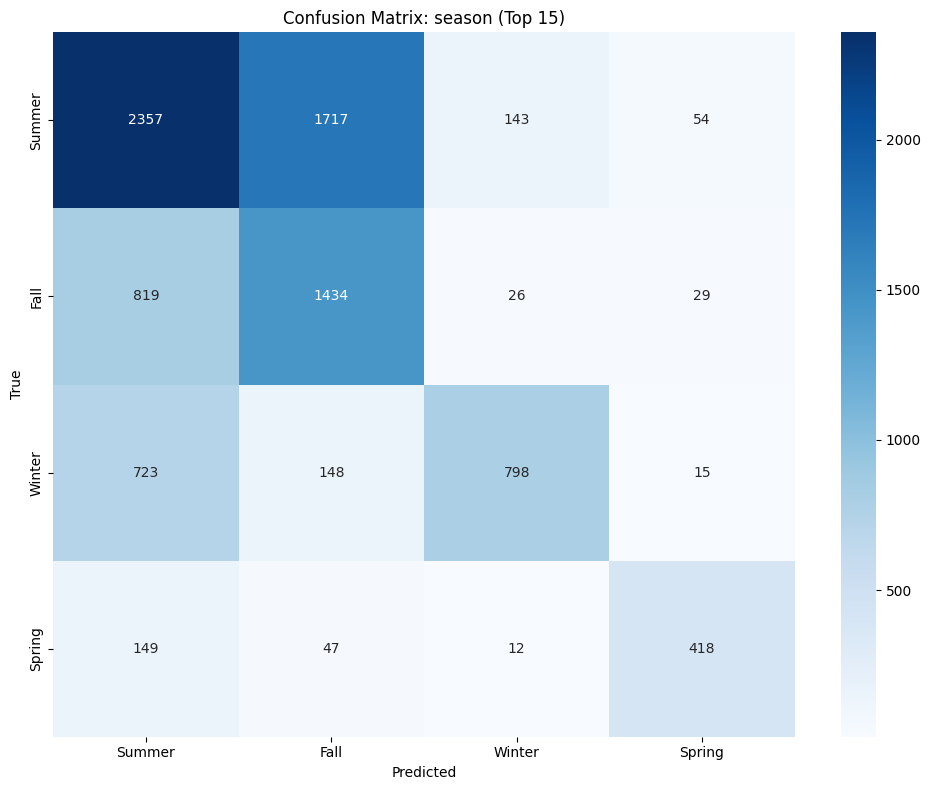

Confusion Matrix for 'usage'


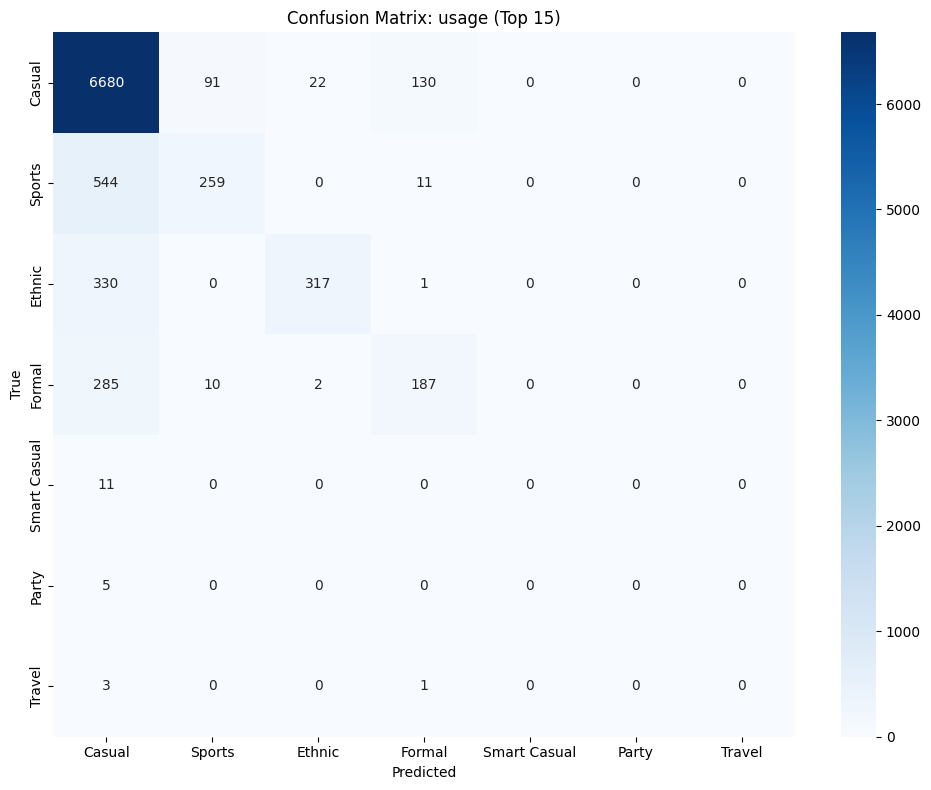

Confusion Matrix for 'brandName'


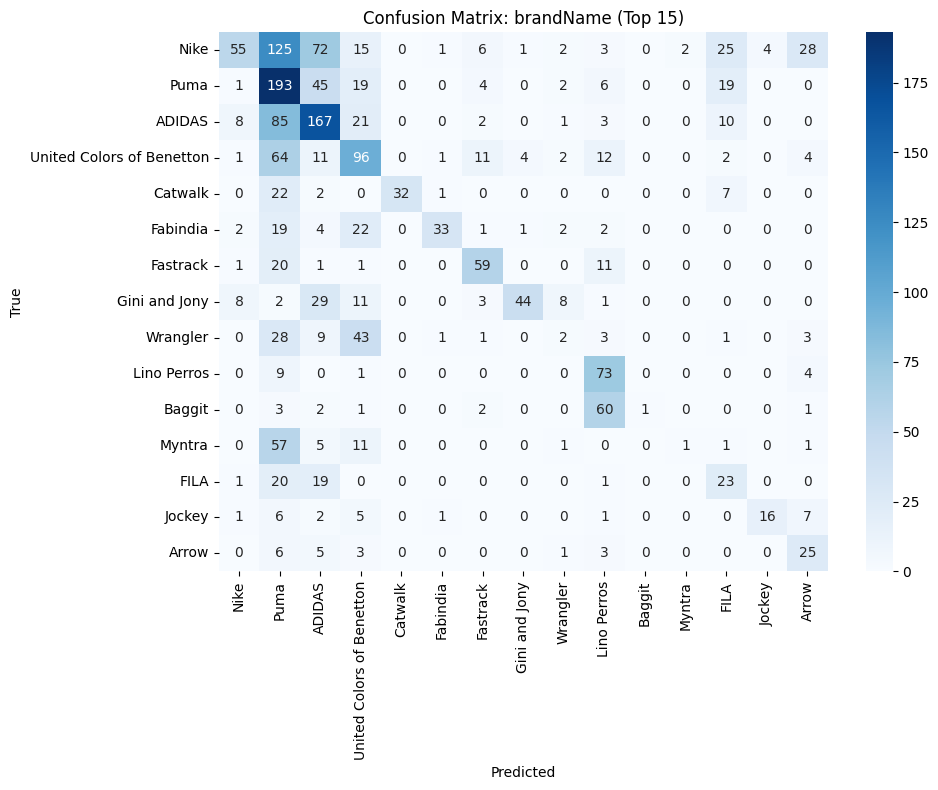

In [80]:
all_preds, all_trues = get_predictions_and_labels(model, val_ds, target_cols)

# Plot confusion matrices for each target
for col in target_cols:
    le = label_encoders[col]
    class_labels = le.classes_
    print(f"Confusion Matrix for '{col}'")
    plot_confusion_matrix_topN(all_trues[col], all_preds[col], labels=class_labels, title=f"Confusion Matrix: {col}")


### Classification Reports:

In [ ]:
def print_classification_reports(model, val_ds, target_cols):
    # Predict on the validation dataset
    y_pred_raw = model.predict(val_ds, verbose=0)

    # Prepare y_true dictionary to store true labels
    y_true = {col: [] for col in target_cols}
    
    # Collect the true labels from the validation set
    for _, label_dict in val_ds:
        for col in target_cols:
            y_true[col].extend(label_dict[col].numpy().tolist())

    # Convert y_true to numpy arrays
    y_true = {col: np.array(y_true[col], dtype=np.int32) for col in target_cols}

    # Generate predicted labels (argmax for each target column)
    y_pred = {
        col: np.argmax(y_pred_raw[col], axis=1)
        for col in target_cols
    }

    # Print the classification reports
    print("\n" + "="*60)
    print("Classification Reports".center(60))
    print("="*60)

    for col in target_cols:
        print(f"\n{'-'*60}\nTarget: {col}\n{'-'*60}")
        report = classification_report(
            y_true[col],
            y_pred[col],
            zero_division=0,
            digits=4
        )
        print(report)

In [82]:
print_classification_reports(model, val_ds, target_cols)

I0000 00:00:1752813164.752422      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:4983484423079994877
E0000 00:00:1752813165.261516      10 meta_optimizer.cc:966] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node functional_1/articleType_1/BiasAdd/ReadVariableOp.
I0000 00:00:1752813166.274296     808 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(15983728369485994134), session_name()
I0000 00:00:1752813174.327434     808 tpu_compile_op_common.cc:245] Compilation of 15983728369485994134 with session name  took 8.053062515s and succeeded
I0000 00:00:1752813174.341887     808 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(15983728369485994134), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_4983484423079994877", property.function_library_fingerprint = 14703705475768374549, property.mlir_module_fin


                   Classification Reports                   

------------------------------------------------------------
Target: gender
------------------------------------------------------------
              precision    recall  f1-score   support

           0     0.7670    0.5032    0.6077       157
           1     0.7531    0.4656    0.5755       131
           2     0.8430    0.9715    0.9027      4489
           3     0.6386    0.4818    0.5492       440
           4     0.9606    0.8371    0.8946      3672

    accuracy                         0.8760      8889
   macro avg     0.7925    0.6519    0.7059      8889
weighted avg     0.8788    0.8760    0.8718      8889


------------------------------------------------------------
Target: masterCategory
------------------------------------------------------------
              precision    recall  f1-score   support

           0     0.9616    0.9837    0.9725      2214
           1     0.9953    0.9859    0.9906      4260
  

# Error Analysis

In [95]:
def find_missclassified_per_target_feature(
    target_feature, label_encoders,
    all_images, all_true_labels, all_pred_labels, target_cols,
    num_samples=5, shuffle=True
):
    """
    Show random misclassified images for a given target_feature,
    without filtering by a specific class.
    """
    # Find misclassified indices for the target feature
    idx_list = np.where(
        all_true_labels[target_feature] != all_pred_labels[target_feature]
    )[0]

    if len(idx_list) == 0:
        print(f"No misclassified samples found for feature '{target_feature}'.")
        return

    if shuffle:
        np.random.shuffle(idx_list)

    print(f"Found {len(idx_list)} misclassified samples. Showing up to {num_samples}...\n")
    idx_list = idx_list[:num_samples]


    for idx in idx_list:
        img = all_images[idx]
        plt.imshow(img)
        plt.axis("off")
        title_lines = []

        for col in target_cols:
            true_label = label_encoders[col].inverse_transform([all_true_labels[col][idx]])[0]
            pred_label = label_encoders[col].inverse_transform([all_pred_labels[col][idx]])[0]
            if col == target_feature:
                line = f"*** {col}: TRUE={true_label} | PRED={pred_label} *** "
            else:
                line = f"{col}: TRUE={true_label} | PRED={pred_label}"
            title_lines.append(line)

        plt.title("\n".join(title_lines), fontsize=10)
        plt.show()

def find_missclassified_per_class(
    target_feature, target_class, label_encoders,
    all_images, all_true_labels, all_pred_labels, target_cols,
    num_samples=5, shuffle=True
):
    """
    Show misclassified images where the true label is 'target_class' but the prediction is different.
    """
    target_class_encoded = label_encoders[target_feature].transform([target_class])[0]

    idx_list = np.where(
        (all_true_labels[target_feature] == target_class_encoded) &
        (all_pred_labels[target_feature] != target_class_encoded)
    )[0]

    if len(idx_list) == 0:
        print(f"No misclassified samples found for class '{target_class}' in '{target_feature}'")
        return

    if shuffle:
        np.random.shuffle(idx_list)

    print(f"Found {len(idx_list)} misclassified samples. Showing up to {num_samples}...\n")

    for idx in idx_list[:num_samples]:
        img = all_images[idx]
        plt.imshow(img)
        plt.axis("off")
        title_lines = []

        for col in target_cols:
            true_label = label_encoders[col].inverse_transform([all_true_labels[col][idx]])[0]
            pred_label = label_encoders[col].inverse_transform([all_pred_labels[col][idx]])[0]
            if col == target_feature:
                line = f"*** {col}: TRUE={true_label} | PRED={pred_label} *** "
            else:
                line = f"{col}: TRUE={true_label} | PRED={pred_label}"
            title_lines.append(line)

        plt.title("\n".join(title_lines), fontsize=10)
        plt.show()

def find_specific_misclassifications(
    target_feature, true_class, predicted_as_class,
    label_encoders, all_images, all_true_labels, all_pred_labels,
    target_cols, num_samples=5, shuffle=True
):
    """
    Show images where 'true_class' was misclassified specifically as 'predicted_as_class'
    for a given target feature.
    """
    true_encoded = label_encoders[target_feature].transform([true_class])[0]
    pred_encoded = label_encoders[target_feature].transform([predicted_as_class])[0]

    idx_list = np.where(
        (all_true_labels[target_feature] == true_encoded) &
        (all_pred_labels[target_feature] == pred_encoded)
    )[0]

    if len(idx_list) == 0:
        print(f"No samples of '{true_class}' misclassified as '{predicted_as_class}' in '{target_feature}'")
        return

    if shuffle:
        np.random.shuffle(idx_list)

    print(f"Found {len(idx_list)} samples of '{true_class}' misclassified as '{predicted_as_class}'. Showing up to {num_samples}...\n")

    for idx in idx_list[:num_samples]:
        img = all_images[idx]
        plt.imshow(img)
        plt.axis("off")
        title_lines = []

        for col in target_cols:
            true_label = label_encoders[col].inverse_transform([all_true_labels[col][idx]])[0]
            pred_label = label_encoders[col].inverse_transform([all_pred_labels[col][idx]])[0]
            if col == target_feature:
                line = f"*** {col}: TRUE={true_label} | PRED={pred_label} *** "
            else:
                line = f"{col}: TRUE={true_label} | PRED={pred_label}"
            title_lines.append(line)

        plt.title("\n".join(title_lines), fontsize=10)
        plt.show()

def decode_label(label_encoders, target_feature, encoded_value):
    """
    Given a target feature and its encoded label, returns the original label.
    
    Args:
        label_encoders (dict): Dictionary of LabelEncoders for each target feature.
        target_feature (str): The feature name whose label you want to decode.
        encoded_value (int): The encoded integer value to decode.
        
    Returns:
        str: The original string label.
    """
    le = label_encoders.get(target_feature)
    if le is None:
        raise ValueError(f"No label encoder found for feature: {target_feature}")
    
    # Check if the encoded value is within valid range
    if encoded_value < 0 or encoded_value >= len(le.classes_):
        raise ValueError(f"Encoded value {encoded_value} is out of range for feature '{target_feature}'.")

    return le.inverse_transform([encoded_value])[0]

In [84]:
# Precompute predictions for val_ds
val_predictions = model.predict(val_ds, verbose=1)

# Collect true labels and image tensors
all_true_labels = {col: [] for col in target_cols}
all_pred_labels = {col: np.argmax(val_predictions[col], axis=1) for col in target_cols}
all_images = []
all_image_paths = []

for (images, labels) in val_ds:
    all_images.extend(images.numpy())
    for col in target_cols:
        all_true_labels[col].extend(labels[col].numpy())

# Optional: convert true labels to numpy arrays for easier indexing
for col in target_cols:
    all_true_labels[col] = np.array(all_true_labels[col])

70/70 ━━━━━━━━━━━━━━━━━━━━ 16s 213ms/step


## Errors for ***baseColour***:

### Results of Analysis from 20 Missclassified Samples:
- Model Being Unable to Distinguish: 12
- Incorrect Labeling: 5
- Model Doesn't Know Where to Look in the Image: 3

Found 4979 misclassified samples. Showing up to 20...



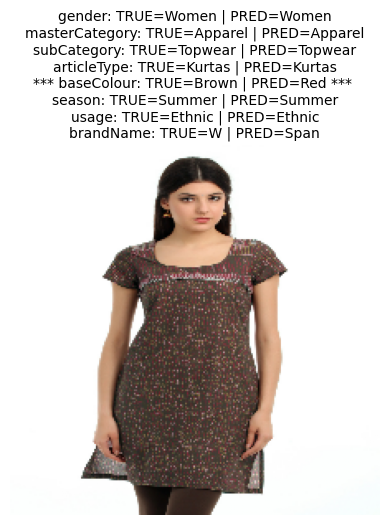

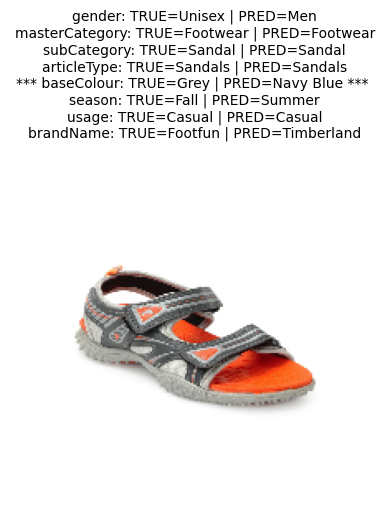

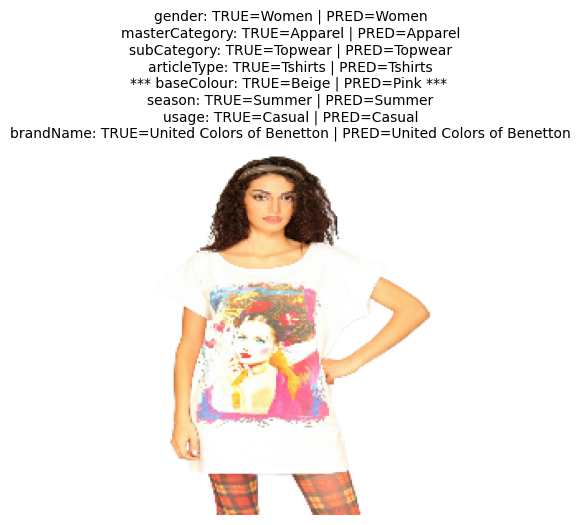

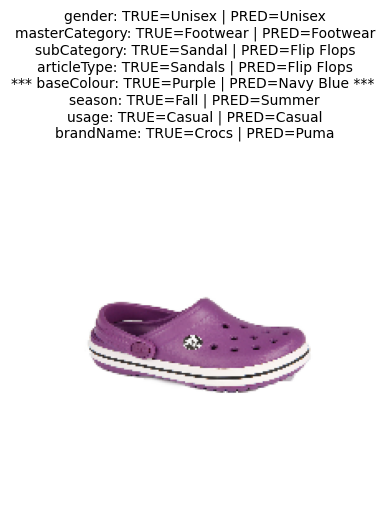

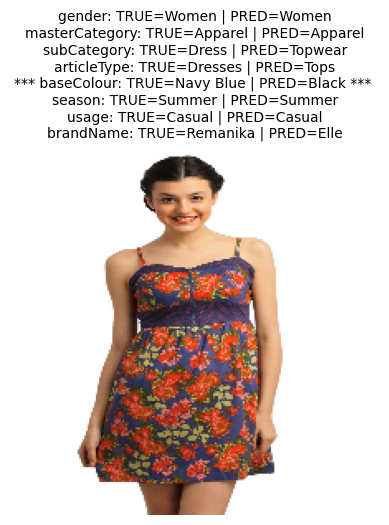

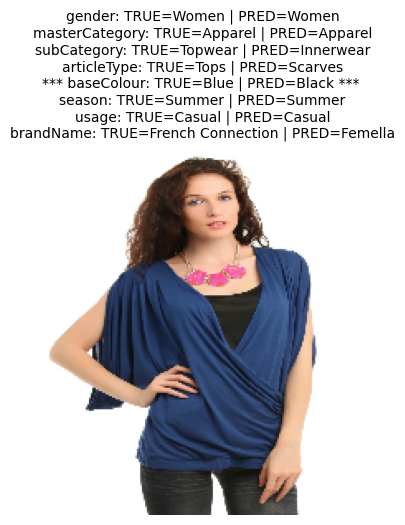

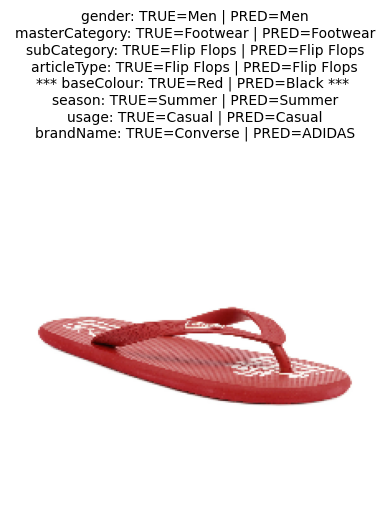

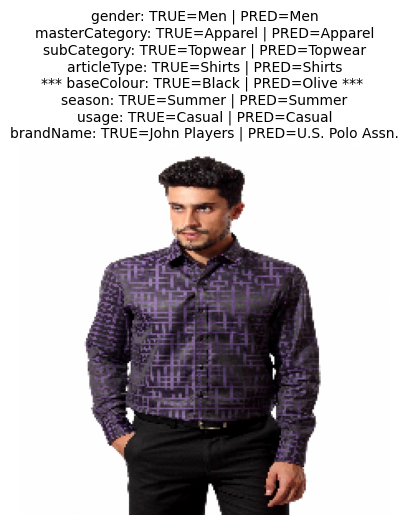

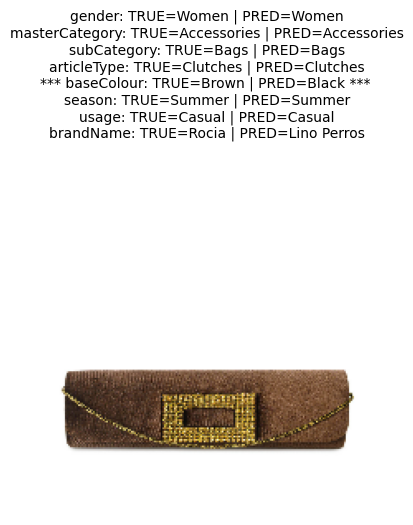

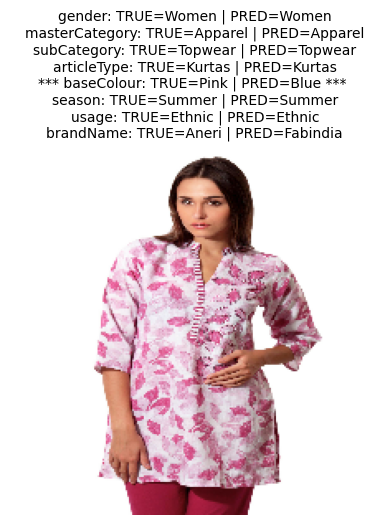

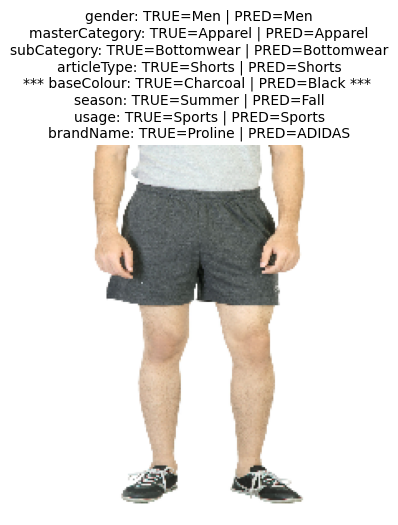

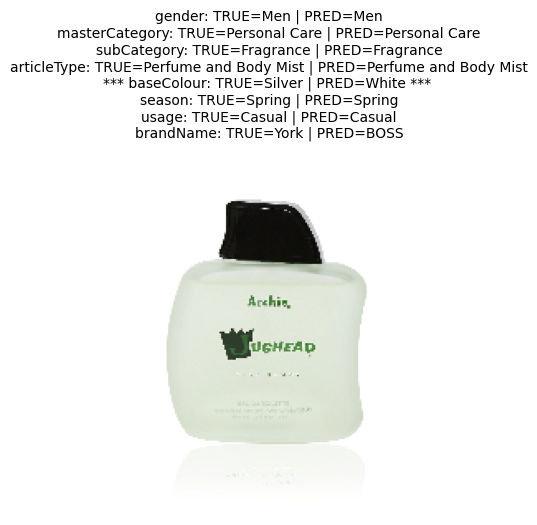

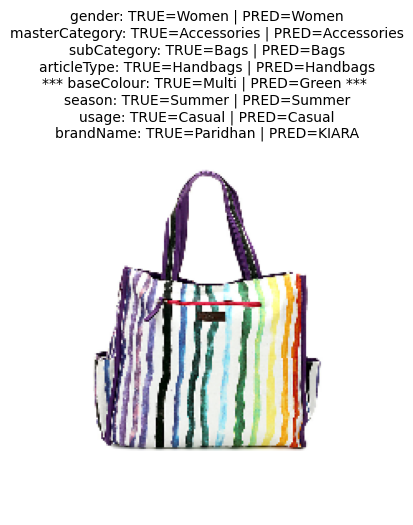

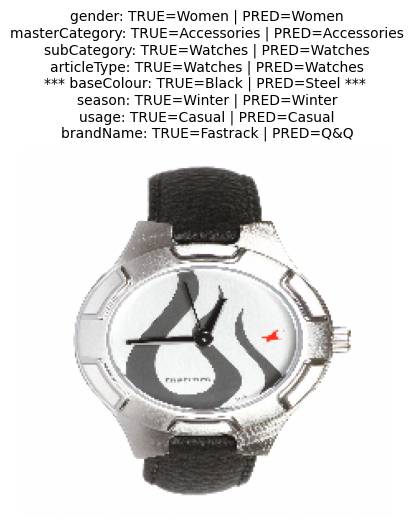

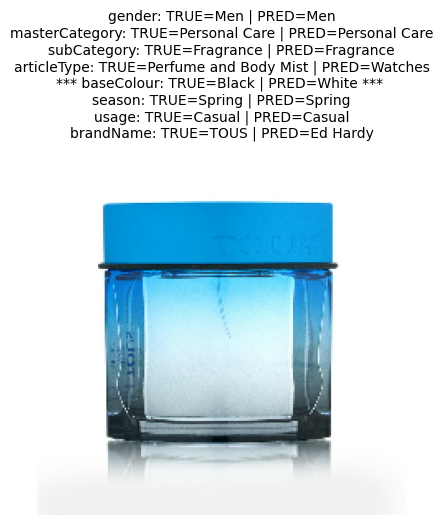

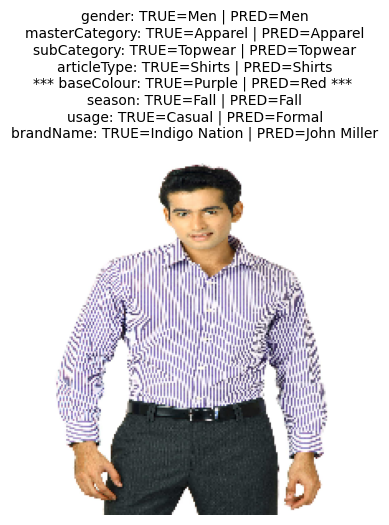

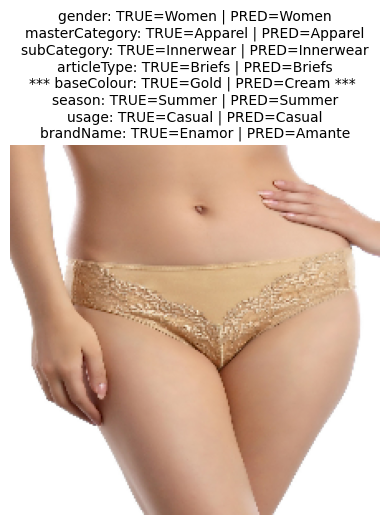

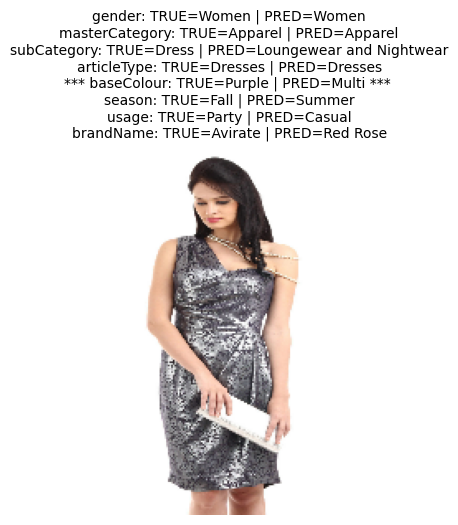

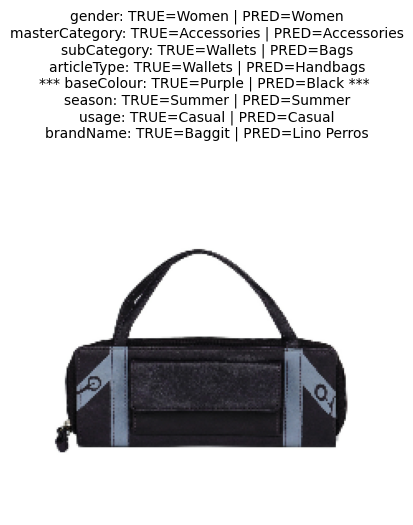

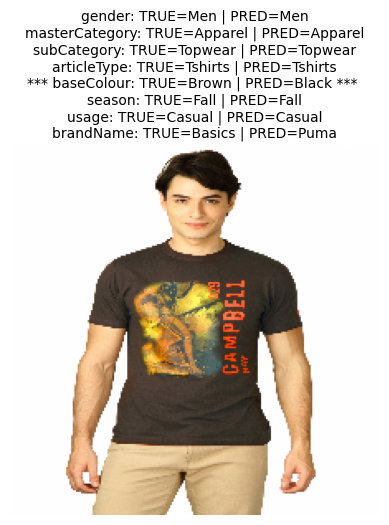

In [98]:
find_missclassified_per_target_feature(
    target_feature="baseColour",
    label_encoders=label_encoders,
    all_images=all_images,
    all_true_labels=all_true_labels,
    all_pred_labels=all_pred_labels,
    target_cols=target_cols,
    num_samples=20
)

## Errors for ***brandName***

### Results of Analysis from 20 Missclassified Samples:
- Model Being Unable to Distinguish due to Limited Capability: 4
- Model Being Unable to Distinguish due to Image Quality: 9
- No Brand in the Image: 7

Found 6181 misclassified samples. Showing up to 20...



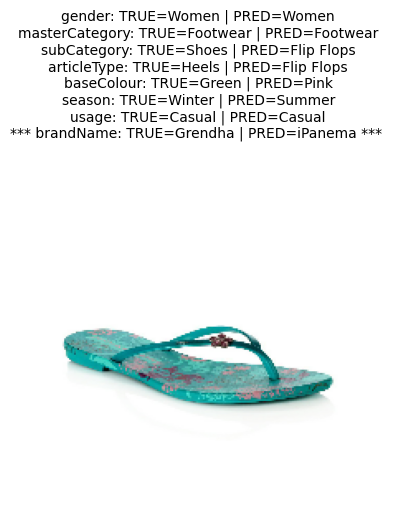

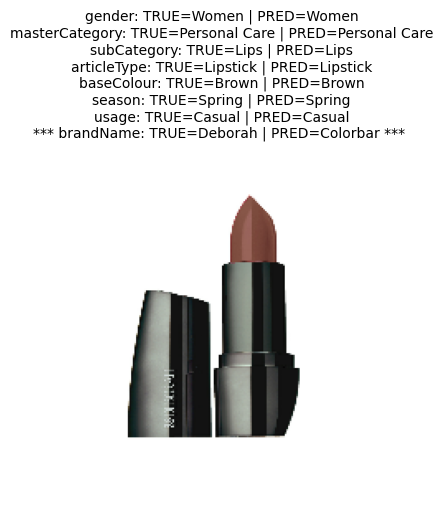

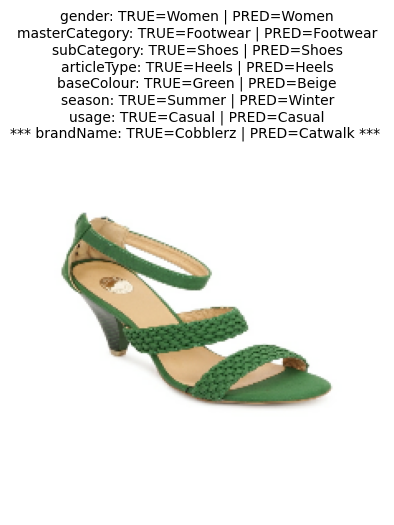

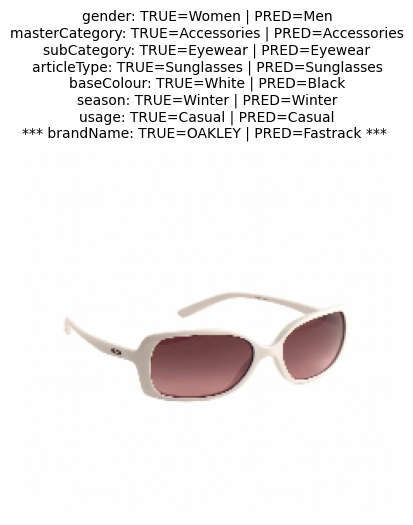

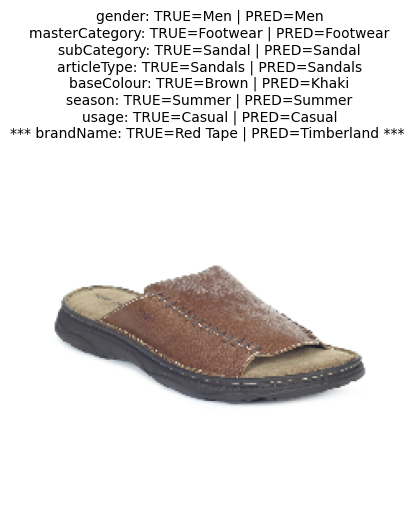

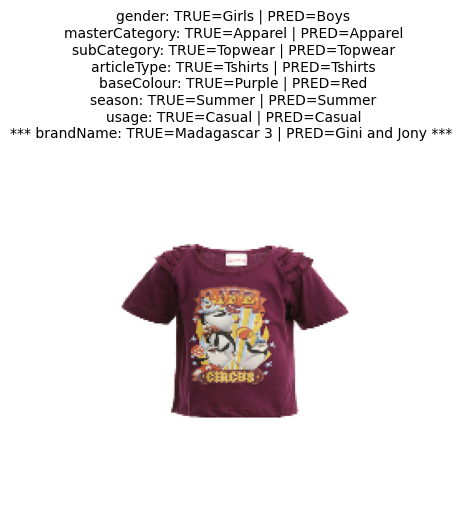

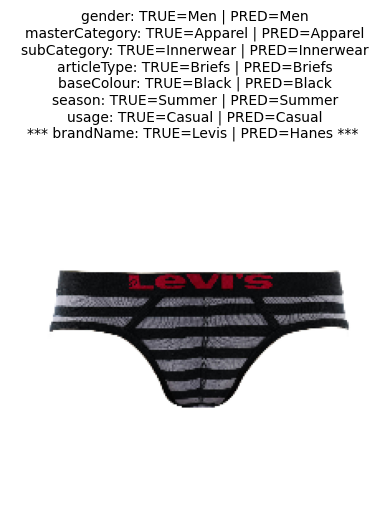

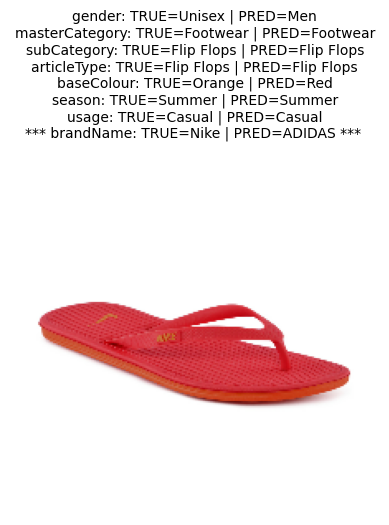

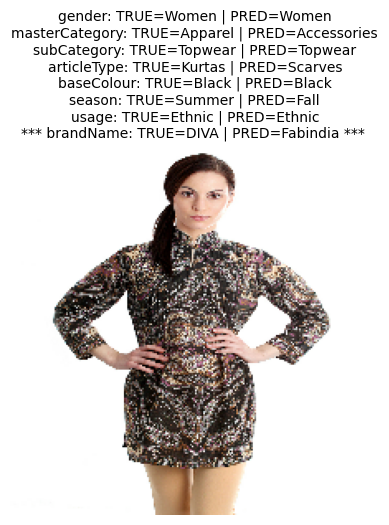

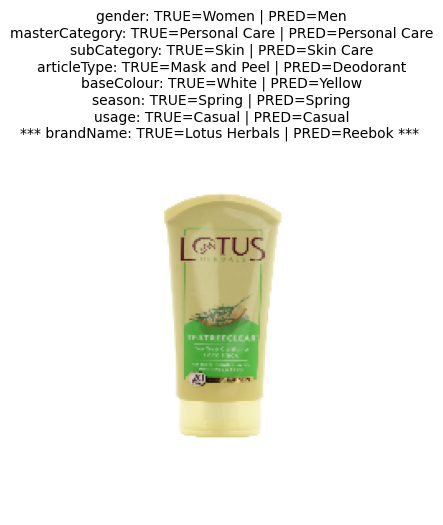

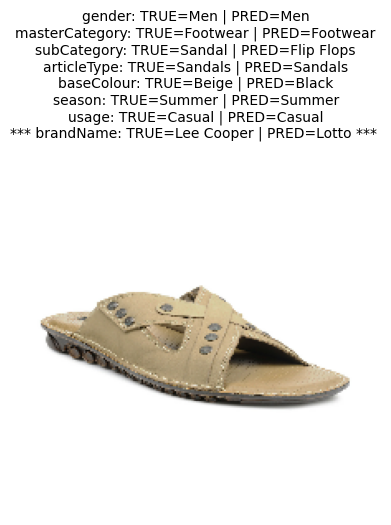

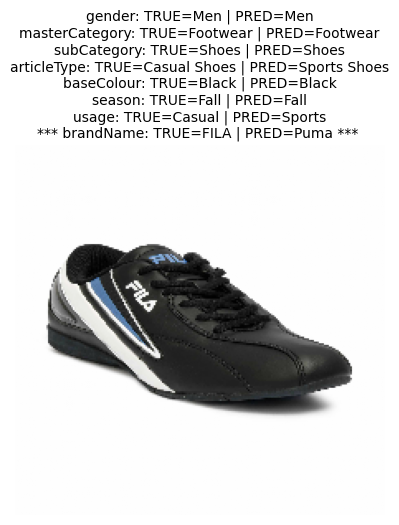

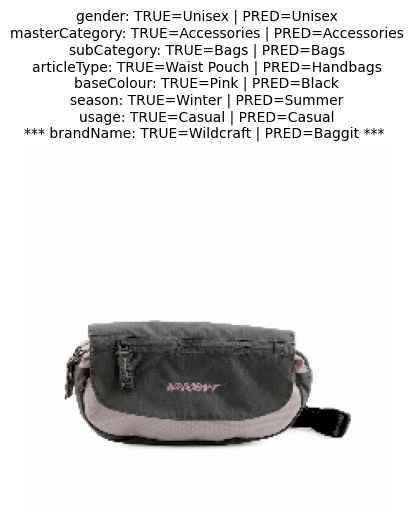

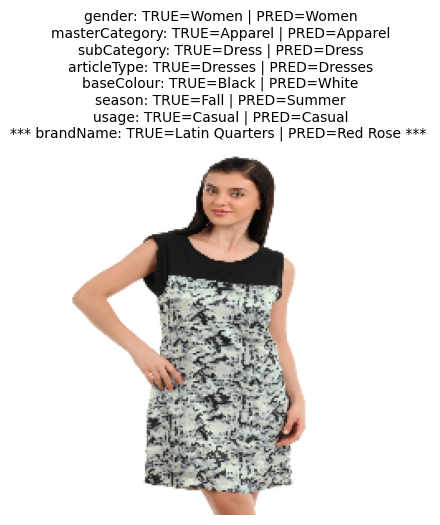

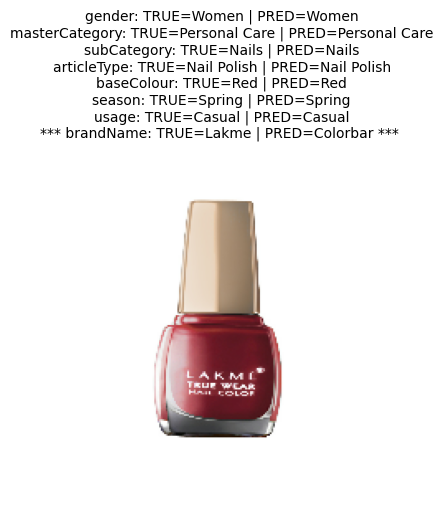

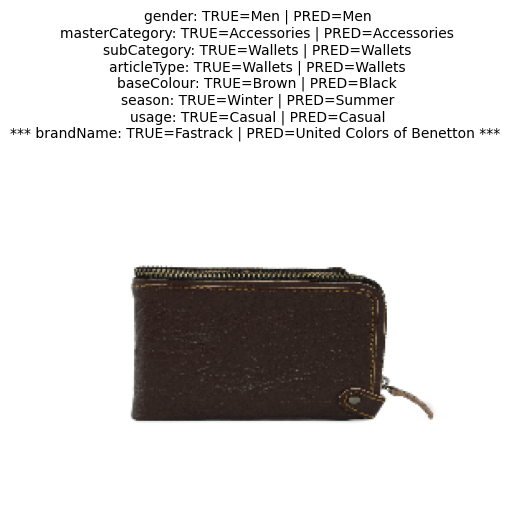

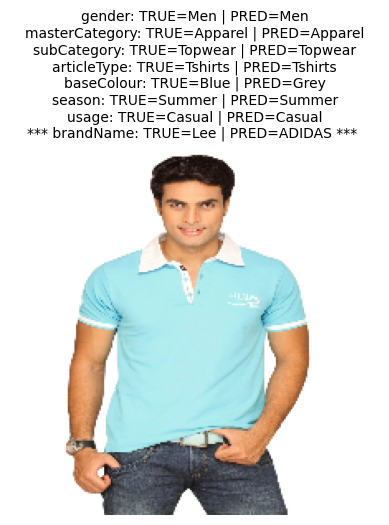

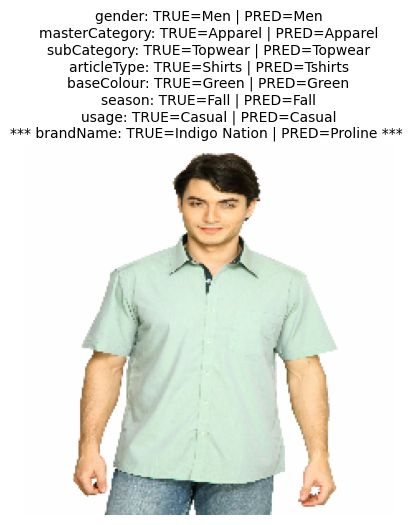

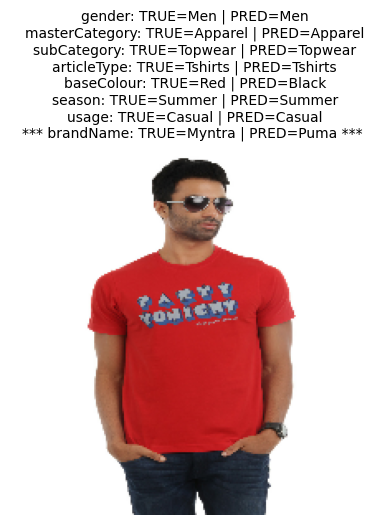

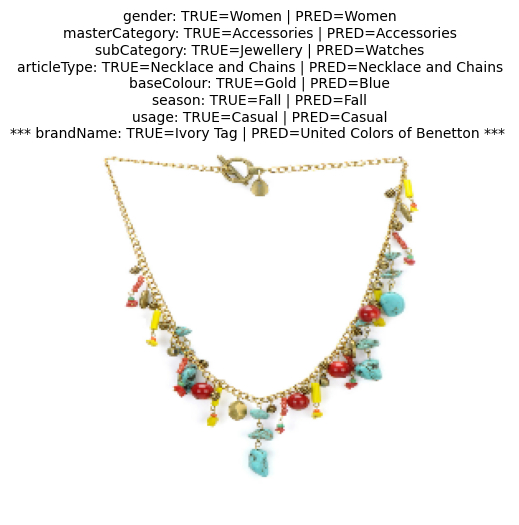

In [97]:
find_missclassified_per_target_feature(
    target_feature="brandName",
    label_encoders=label_encoders,
    all_images=all_images,
    all_true_labels=all_true_labels,
    all_pred_labels=all_pred_labels,
    target_cols=target_cols,
    num_samples=20
)